In [1]:
# Auto reload of modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Import
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, pinvh

from rates.auxillary import (
    label_graph,
    cat2one_hot,
    copy_matrix
)
from rates.config import SAVE_DIR
from rates.datasets import circles, mixture
from rates.architectures import exp_kernel

# Config
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')

noise_level = 0
# circles = mixture
# noise_level = .3

In [3]:
def query_and_update(ind_int, y, i_query, ind_known, real_T, new_T, queried):
    # collect positive answers
    ind_int_pos = ind_int[y[ind_int] == i_query + 1]

    # deduced new labels and fill graph
    ind_known[ind_int_pos] = True
    ind_int_known = np.arange(len(y))[ind_known]
    copy_matrix(real_T, new_T, ind_int_known, ind_int_known)

    # deduced negative pairs and fill graph
    ind_int_neg = ind_int[y[ind_int] != i_query + 1]
    ind_int_pos = ind_int_known[y[ind_known] == i_query + 1]
    copy_matrix(real_T, new_T, ind_int_pos, ind_int_neg)
    copy_matrix(real_T, new_T, ind_int_neg, ind_int_pos)

    # remember queried points
    queried[ind_int_known, :] = True
    queried[ind_int, i_query] = True


In [4]:
sigma = .2
lambd = 1e-3

In [5]:
n_train = 300
d = 4
n_test = 1000

x_test, y_test = circles(n_test, d=d, noise_level=noise_level, labels=True, test=True)
one_hot = cat2one_hot(y_test.astype(int) - 1)

In [6]:
# np.random.seed(0)

nb_trials = 100
nb_trials_distill = 1
nb_distill = (d * (n_train // d)** 2 - n_train) // 2
nb_distill = 80
mul_factor = 10
errors_con = np.zeros((nb_trials, nb_trials_distill, nb_distill))
errors_non = np.zeros((nb_trials, nb_trials_distill, nb_distill))


for i in range(nb_trials):
    x, y = circles(n_train, d=d, noise_level=noise_level, labels=True, test=False)
    one_hot_train = cat2one_hot(y.astype(int) - 1)

    # Begin with one known example per class
    tmp = np.zeros((len(y), d))
    for j in range(d):
        tmp[np.argmax(y == j + 1), j] = 1
    ind_known = np.sum(tmp, axis=1).astype(bool)

    K = exp_kernel(x, x, sigma=sigma)
    K_test = exp_kernel(x_test, x, sigma=sigma)
    K_inv = pinvh(K, atol=1e-5 / n_train)
    K_inv *= lambd

    # Precomputation
    tmp_x = K @ K_inv
    tmp_x_test = K_test @ K_inv

    real_T = label_graph(y)

    for j in range(nb_trials_distill):
        T_con = np.eye(len(x))
        T_non = np.eye(len(x))

        # As training pass by, we deduce labels
        ind_known_active = ind_known.copy()

        # To avoid querying twice the same pairs
        queried_active = np.zeros((n_train, d), dtype=bool)

        for k in range(nb_distill):

            # contrastive learning
            T_l = T_con - K_inv
            w, v = eigh(T_l, subset_by_index=[len(T_l) - 5, len(T_l) - 1])

            # ...compute best test error
            phi = tmp_x_test @ v
            w = np.linalg.solve(phi.T @ phi, phi.T @ one_hot)
            pred = np.argmax(phi @ w, axis=1)
            errors_con[i, j, k] = (pred + 1 != y_test).mean()

            # noncontrastive learning
            T_l = T_non - K_inv
            w, v = eigh(T_l, subset_by_index=[len(T_l) - 5, len(T_l) - 1])

            # ...compute best test error
            phi = tmp_x_test @ v
            w = np.linalg.solve(phi.T @ phi, phi.T @ one_hot)
            pred = np.argmax(phi @ w, axis=1)
            errors_non[i, j, k] = (pred + 1 != y_test).mean()

            # ...select class to query against
            i_query = queried_active.sum(axis=0).argmin()

            # ...choose points to query
            ind = ~ind_known_active
            ind &= ~queried_active[:, i_query]
            ind_int = np.arange(len(y))[ind]
            # ...choose a small subset of points to query
            if len(ind_int) >= mul_factor:
                ind_int = np.random.choice(ind_int, mul_factor)

            # ...collect the query and update graph
            query_and_update(ind_int, y, i_query, ind_known_active, 2*real_T-1, T_con, queried_active)
            query_and_update(ind_int, y, i_query, ind_known_active, real_T, T_non, queried_active)
            
    print(i, end=",", flush=True)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

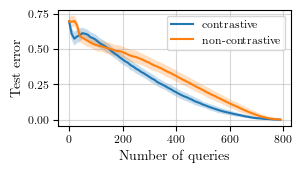

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
tmp_x = mul_factor * np.arange(nb_distill)

errors = errors_con
ax.plot(tmp_x, errors.mean(axis=(0,1)), label="contrastive")
ax.fill_between(tmp_x, errors.mean(axis=(0,1)) - errors.std(axis=(0,1)), errors.mean(axis=(0,1)) + errors.std(axis=(0,1)), alpha=.25)

errors = errors_non
ax.plot(tmp_x, errors.mean(axis=(0,1)), label="non-contrastive")
ax.fill_between(tmp_x, errors.mean(axis=(0,1)) - errors.std(axis=(0,1)), errors.mean(axis=(0,1)) + errors.std(axis=(0,1)), alpha=.25)

ax.set_xlabel("Number of queries")
ax.set_ylabel("Test error")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8)
ax.legend(fontsize=8, loc="upper right")
ax.grid(alpha=.5)
# fig.savefig(SAVE_DIR / "contrastive.pdf", bbox_inches='tight', pad_inches=0)

In [8]:
n_display_root = 100
tmp = np.linspace(-(d+1), (d+1), n_display_root)
X, Y = np.meshgrid(tmp, tmp)
x_display = np.vstack((X.flatten(), Y.flatten())).T
K_display = exp_kernel(x_display, x, sigma=sigma)
phi_display = K_display @ (K_inv @ v)


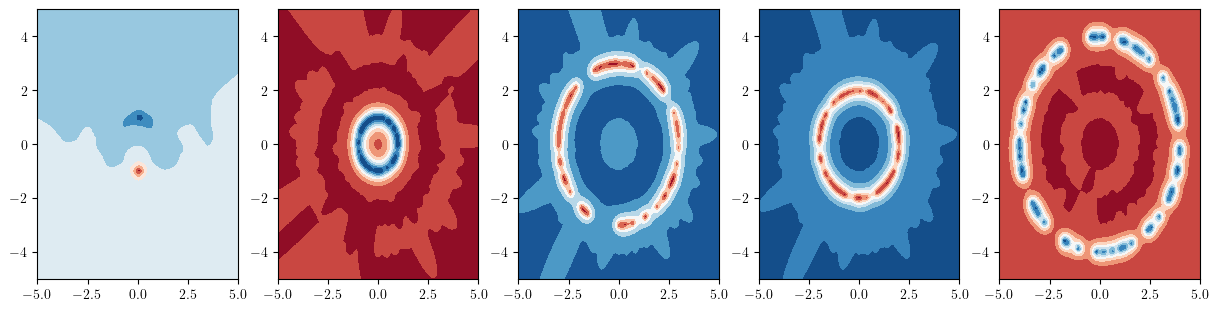

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3.5))
for j in range(phi.shape[1]):
    axes[j].contourf(X, Y, phi_display[:, j].reshape(*X.shape), cmap='RdBu')

[]

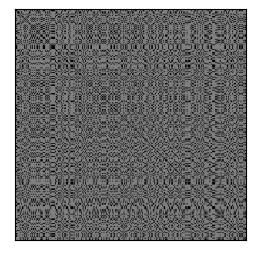

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(real_T, vmin=-1, vmax=1, cmap="gray_r")
ax.set_xticks([])
ax.set_yticks([])